In [1]:
%matplotlib inline

from strip_catalogue import get_raw_course_list, get_quarter_offerings
from scrapercleaner import clean_scrape
import networkx as nx
import re
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

1
{'ECE 109', 'PHYS 4B', 'MATH 3C', 'MATH 31AH', 'ECE 25', 'MATH 4C', 'ECE 35', 'MATH 10B', 'MATH 10A', 'ECE 161', 'ECE 161C', 'ECE 100', 'MATH 20A', 'ECE 15', 'MATH 10C', 'MATH 31BH', 'MATH 20C', 'MATH 20F', 'PHYS 2C', 'ECE 161A', 'ECE 101', 'MATH 20D', 'PHYS 2A', 'MATH 18', 'MATH 21C', 'ECE 107', 'ECE 45', 'MATH 20B', 'ECE 30', 'ECE 5', 'PHYS 4A', 'PHYS 2B', 'ECE 152A', 'ECE 65', 'PHYS 4C', 'ECE 161B', 'ECE 153'}
[['MATH 3C', 'ECE 25', 'ECE 15'], ['ECE 30', 'ECE 5'], ['MATH 31AH', 'MATH 4C'], ['MATH 10A', 'MATH 31BH', 'MATH 18'], ['MATH 10B', 'MATH 20A'], ['MATH 10C', 'MATH 20D', 'MATH 20B'], ['ECE 109', 'MATH 20C', 'PHYS 2A'], ['PHYS 4B', 'ECE 35', 'ECE 153'], ['ECE 45', 'PHYS 2B', 'ECE 65'], ['ECE 100', 'PHYS 2C', 'ECE 101'], ['ECE 107'], ['ECE 161A'], ['PHYS 4A', 'ECE 161B'], ['ECE 161C'], ['PHYS 4C']]
1
{'ECE 109', 'PHYS 4B', 'MATH 3C', 'MATH 31AH', 'ECE 25', 'MATH 4C', 'ECE 35', 'MATH 10B', 'MATH 10A', 'ECE 161', 'ECE 161C', 'ECE 100', 'MATH 20A', 'ECE 15', 'MATH 10C', 'MATH 31B

1
{'ECE 109', 'PHYS 4B', 'MATH 3C', 'MATH 31AH', 'ECE 25', 'MATH 4C', 'ECE 35', 'MATH 10B', 'MATH 10A', 'ECE 161C', 'ECE 100', 'MATH 20A', 'ECE 15', 'MATH 10C', 'MATH 31BH', 'MATH 20C', 'PHYS 2C', 'PHYS 4C', 'ECE 161A', 'ECE 101', 'MATH 20D', 'PHYS 2A', 'MATH 18', 'ECE 152A', 'ECE 107', 'ECE 45', 'MATH 20B', 'ECE 30', 'ECE 5', 'PHYS 4A', 'PHYS 2B', 'ECE 161', 'ECE 65', 'MATH 21C', 'ECE 161B', 'ECE 153'}
[['MATH 3C', 'ECE 25', 'ECE 15'], ['ECE 30', 'ECE 5'], ['MATH 31AH', 'MATH 4C'], ['MATH 10A', 'MATH 20A', 'MATH 31BH'], ['MATH 10B', 'MATH 18'], ['MATH 10C', 'MATH 20D', 'MATH 20B'], ['ECE 109', 'MATH 20C', 'PHYS 2A'], ['ECE 35', 'PHYS 2C', 'PHYS 2B'], ['PHYS 4C', 'ECE 45', 'ECE 65'], ['ECE 100', 'ECE 101', 'ECE 107'], ['ECE 153'], ['ECE 161A'], ['PHYS 4A', 'ECE 161B'], ['PHYS 4B', 'ECE 161C']]
1
{'ECE 109', 'MATH 3C', 'PHYS 4B', 'MATH 31AH', 'ECE 25', 'MATH 4C', 'ECE 35', 'MATH 10B', 'MATH 10A', 'ECE 161', 'ECE 161C', 'ECE 100', 'MATH 20A', 'ECE 15', 'MATH 10C', 'MATH 31BH', 'MATH 20C'

In [2]:
def get_avg_num_prereqs(courses, undergrad=False):
    """
    Gets average number of prereqs for given courses, optionally only for undergrad.
    Input should be same format as clean_scrape().
    :param courses: list of courses, same as output of clean_scrape()
    :type courses: list or tuple
    :param undergrad: whether only undergrad should be considered
    :type undergrad: true
    :return: int
    """
    assert isinstance(courses, list) or isinstance(courses, tuple)
    assert isinstance(undergrad, bool)
    sum = 0
    count = 0
    for (course, prereqs) in courses:
        if undergrad:
            num = re.findall('\d+', course)[0]
            if int(num) >= 200:
                continue
        if prereqs:
            sum += len(prereqs)
            count += 1
    return sum/count

In [3]:
def generate_graph(dept, courses, undergrad=False):
    """
    Generates a graph for testing, based on a list of courses (see scrapercleaner.clean_scrape() for format).
    :param dept: department name
    :type dept: str
    :param courses: list of courses from clean_scrape()
    :type courses: list or tuple
    :param undergrad: whether only undergrad should be considered
    :type undergrad: true
    :return: networkx.DiGraph
    """
    assert isinstance(dept, str)
    assert isinstance(courses, list) or isinstance(courses, tuple)
    assert isinstance(undergrad, bool)

    indep_courses = []
    prereqs = []
    for course in courses:
        k, v = course
        # remove grad classes
        if undergrad:
            num = re.findall('\d+', k)[0]
            if int(num) >= 200:
                continue
        if v:
            for i in v:
                weight = len(i)
                for j in i:
                    if j.startswith(dept):
                        prereqs.append([j.split()[1].lstrip("0"), k, 1/weight])
        # if no prereqs, add as independent node
        else:
            indep_courses.append(k.lstrip("0"))

    G = nx.DiGraph()
    G.add_nodes_from(indep_courses)
    G.add_weighted_edges_from(prereqs)
    return G

In [4]:
def find_root(G, child):
    """
    Find the root of any given node.
    :param G: graph to search
    :type G: networkx.DiGraph
    :param child: child node to find root
    :type child: str
    :return: str
    """
    assert isinstance(G, nx.classes.digraph.DiGraph)
    assert isinstance(child, str)

    parent = list(G.predecessors(child))
    if len(parent) == 0:
        return child
    else:
        return find_root(G, parent[0])

def get_flexibility(G):
    """
    Computes the number of paths between each end node and all root nodes and divides by total number of nodes.
    :param G: graph to analyze
    :type G: networkx.DiGraph
    :return: float
    """
    assert isinstance(G, nx.classes.digraph.DiGraph)

    heads = set()
    for i in G.nodes:
        r = find_root(G, i)
        if r != i:
            heads.add(r)
    tails = [n for n in G.nodes() if G.out_degree(n) == 0]
    sum = 0
    for h in heads:
        for t in tails:
            sum += len(list(nx.all_simple_paths(G,h,t)))
    return sum/G.number_of_nodes()

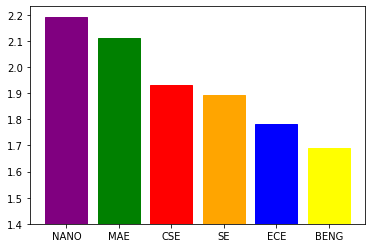

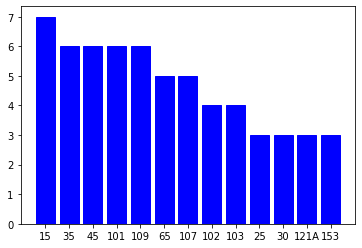

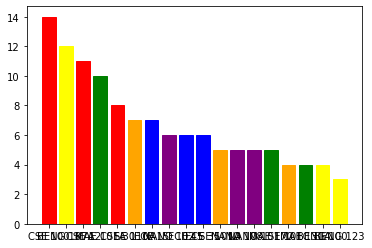

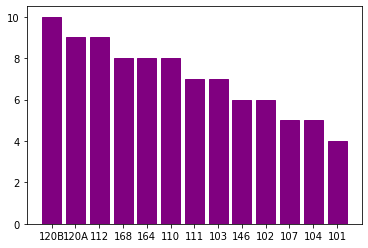

In [5]:
depts = ['ECE', 'CSE', 'MAE', 'BENG', 'NANO', 'SE']
colors = {'CSE': 'red', 'ECE': 'blue', 'MAE': 'green', 'NANO': 'purple', 'SE': 'orange', 'BENG': 'yellow'}
avg_prereqs = []
out_degrees = []
ece_out = []
top_ancestors = []
flex = []
for dept in depts:
    raw_courses = get_raw_course_list(dept)
    courses = clean_scrape(raw_courses)
    avg = get_avg_num_prereqs(courses, True)
    avg_prereqs.append([avg, dept])

    G = generate_graph(dept, courses, True)
    out_deg = list(G.out_degree)
    out_deg.sort(key=lambda i: i[1], reverse=True)
    # get top 3 out degrees per major
    for i in range(3):
        out_degrees.append([out_deg[i][1], dept + ' ' + out_deg[i][0]])
    if dept == 'ECE':
        for i in range(13):
            ece_out.append([out_deg[i][1], out_deg[i][0]])

    for n in G.nodes():
        if dept == 'NANO':
            top_ancestors.append([len(nx.algorithms.dag.ancestors(G, n)), n])
    flex.append([get_flexibility(G),dept])

avg_prereqs.sort(reverse=True)
plt.figure()
avg_bar = plt.bar([i[1] for i in avg_prereqs], [i[0]-1.4 for i in avg_prereqs],bottom=1.4)
for i, bar in enumerate(avg_bar):
    bar.set_color(colors[avg_prereqs[i][1]])

plt.figure()
e_out_bar = plt.bar([i[1] for i in ece_out], [i[0] for i in ece_out])
for i, bar in enumerate(e_out_bar):
    bar.set_color(colors['ECE'])    

out_degrees.sort(reverse=True)
plt.figure()
out_bar = plt.bar([i[1] for i in out_degrees], [i[0] for i in out_degrees])
for i, bar in enumerate(out_bar):
    bar.set_color(colors[out_degrees[i][1].split()[0]])
    
top_ancestors.sort(reverse=True)
plt.figure()
top_ancestors = top_ancestors[:13]
anc_bar = plt.bar([i[1] for i in top_ancestors], [i[0] for i in top_ancestors])
for i, bar in enumerate(anc_bar):
    bar.set_color(colors['NANO'])

## Drawing example directed graphs

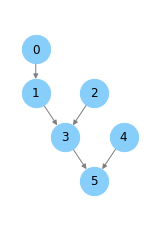

In [6]:
D = nx.DiGraph()
D.add_edge(0,1)
D.add_edge(1,3)
D.add_edge(2,3)
D.add_edge(4,5)
D.add_edge(3,5)
#G.add_edge(45,100)
#G.add_edge(65,100)
#G = nx.generators.directed.gnr_graph(15, 0.3).reverse()

pos = graphviz_layout(D, prog='dot')
#for k, v in pos.items():
#  i,j = v
#  pos[k] = [i/2,j]
scale = 1
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw_networkx(D, pos, arrows=True, with_labels=True, node_size=scale*800, font_size=12, node_color='LightSkyBlue', edge_color=(0.5,0.5,0.5))
plt.axis('off')
plt.margins(x=.25, y=.25)
ax.set_aspect(0.75)
plt.show()

## For the website visualization, see `dash_viz.py` and run it
(Dash interactivity cannot be done in a notebook, so it needs to be run as a standalone server)